<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

**Part 2 - Computing the PDF**

**A) Theory**

Having constructed the CDF $F(y)$ we now turn to constructing its PDF $f(y)$ which must remain positive and integrate to one. While strictly speaking the PDF is the derivative of the CDF, the CDF obtained in **Part 1** is discontinuous and therefore a classical derivative can only be defined within each element $\Omega_e$. At the element facets $\partial \Omega_e$ there is a jump in the CDF. As a consequence $F(y)$ has neither a classical nor a weak derivative at these points, but must instead be defined in terms of a distribution (cf. [Ern, A., Guermond, JL. (2021)](https://doi.org/10.1007/978-3-030-56341-7_4)). To this end we choose to recover the PDF, within each element, via a projection into $L^1(\Omega_Y)$, while the PDF at the element facets must be defined either as a distribution or (equivalently via the Riesz–Markov–Kakutani representation theorem) as a measure (cf. [Rudin, W. (1987)](https://perso.telecom-paristech.fr/decreuse/_downloads/c22155fef582344beb326c1f44f437d2/rudin.pdf)). This distinction leads us to define $f(y)$ in terms of its associated distribution
\begin{equation}
\langle \varphi, f \rangle = \int_{\Omega_Y} \varphi \tilde{f}(y) dy + \int_{\Omega_Y} \varphi d \mu(y),
\end{equation}
where $\tilde{f}(y) \in L^1(\Omega_Y)$ is a density associated with the elements, $\mu(y)$ a measure associated with the element facets and $\varphi \in C_0(\Omega_Y)$ a continuous test function with compact support and uniform convergence.

To recover $\tilde{f}$ within each element, we define the function space $V_{\tilde{f}} $ of $\tilde{f}(y)$ to be
\begin{equation*}
    \tilde{f} \in V_{\tilde{f}} \subset L^1(\Omega_Y), \quad \text{where} \quad \tilde{f}:\Omega_Y \to \mathbb{R}^+ \quad \text{s.t.} \; \int_{\Omega_Y} |\tilde{f}| dy < \infty,
\end{equation*}
followed by a set of basis functions $V_{\tilde{f}} = span\{\varphi_i(y)\}$ such that
\begin{equation*}
    \tilde{f}(y) = \sum_i \tilde{f}_i \varphi_i(y).
\end{equation*}
We then define the projection in each element $e$ as
\begin{equation*}
    \int_{e} \varphi_e \tilde{f}(y) \; dy = \int_{e} \varphi_e \partial_y F(y) \; dy, \quad \text{where} \quad \varphi_e \in V_{e},
\end{equation*}
which upon integrating over all cells $\sum_e \int_e \cdot \; dy = \int_{\Omega_Y} \cdot \; dy$ and accounting for the fact that facets in $L^1(\Omega_Y)$ have measure zero gives
\begin{equation*}
    \int_{\Omega_Y} v \tilde{f}(y) \; dy = \int_{\Omega_Y} v \partial_y F(y) \; dy, \quad \text{where} \quad v \in V_{\tilde{f}}.
\end{equation*}

To recover $\mu(y)$ we consider that at each facet $y_e$ there is a jump in the CDF given by $[[F]]_e = F_+ - F_-$, where the subscripts $+/-$ are used to denote the value of $F(y_e)$ approaching from the right/left. Restricting ourselves to a single facet $\partial e$ we define the distributional derivative by
\begin{equation*}
\int_{\partial e} \varphi \partial_y F \; dy = -\int_{\partial e} (\partial_y \varphi)  F \; dy,
\end{equation*}
for all compactly supported test functions $\varphi \in C_0(\Omega_Y)$ which have uniform convergence (cf. [Ern, A., Guermond, JL. (2021)](https://doi.org/10.1007/978-3-030-56341-7_4)). Evaluating the previous integral from the left and the right of an arbitrary facet for $\epsilon > 0$
\begin{equation*}
\int_{\partial e} \varphi \partial_y F \; dy = \int_{y_e - \epsilon}^{y_e} ( \partial_y \varphi) F \; dy - \int_{y_e}^{y_e + \epsilon} ( \partial_y \varphi) F \; dy,
\end{equation*}
and then taking the limit $\epsilon \to 0$ we obtain
\begin{equation*}
\int_{\partial e} \varphi \partial_y F \; dy = F_- \int_{y_e - \epsilon}^{y_e} \partial_y \varphi \; dy - F_+ \int_{y_e}^{y_e + \epsilon} \partial_y \varphi \; dy = - [[F]]_e \varphi(y_e),
\end{equation*}
which we can rewrite in terms of the delta distribution as
\begin{equation*}
\int_{\partial e} \varphi \partial_y F \; dy = - [[F]]_e \int_{\partial e} \varphi(y) \delta(y - y_e) dy.
\end{equation*}
By the Riesz–Markov–Kakutani representation theorem it follows that a zero order distribution (which includes the delta distribution) can be identified with a measure. To this end we can re-write the distributional derivative over all the cell facets as 
\begin{equation*}
\int_{\Gamma} \varphi \partial_y F \; dS = \int_{\Gamma} \varphi(y) d \mu(y),
\end{equation*}
where $\Gamma = \cup \; \partial \Omega_e$ and the measure $\mu$ is defined in terms of the Dirac measure
\begin{equation*}
\delta(y_e) = \begin{cases} 1 \quad y_e \in \Gamma, \\ 0 \quad \text{otherwise}, \end{cases}
\end{equation*}
as $\mu(y) = -[[F(y)]] \delta(y)$. Defining the PDF $f(y)$ in terms of distribution thus provides a mathematically consistent formulation which allows us to ensure that the projection of derivative of the CDF does not loose mass and enables us to accurately calculate moments of the PDF.

**B) Numerical implementation**

To demonstrate our method of recovering $\tilde{f}$ and the measure $\mu(y)$ associated with the cell facets we will make use of the function 
\begin{equation}
Y(x_1) = \begin{cases} 0 \quad x_1 < 0, \\ x \quad x_1 \geq 0, \end{cases} 
\end{equation}
where $x_1 \in [-1,1]$. This function is useful because its CDF contains a step and therefore its corresponding PDF will contain a Dirac distribution. To simplify the presentation we use the *NumDF* library (imported below) which implements the methods used in **Part 1**. 

In [2]:
from numdf import Ptp
import numpy as np
from firedrake import *

We begin by creating an instance of the *Ptp* class by specify the physical domain $\Omega_X$, the domain of the CDF $\Omega_Y$ and a number of elements. As justified in Part1 a discontinuous piecewise linear 'DG1' function space is selected by default for the CDF.

In [3]:
# Specify the domain sizes and number of elements
ptp = Ptp(Omega_X = {'x1': (-1, 1)}, Omega_Y = {'Y': (-1, 1)}, n_elements=10)

We then specify our function $Y(x_1)$ in terms of the coordinates of the domain and generate its CDF by calling the fit method.

In [4]:
# Extract the coordinates
x1 = ptp.x_coords()
Y = conditional(ge(x1, 0), x1, 0)
density = ptp.fit(Y=Y, quadrature_degree=200)

Using the density object we can then plot the CDF, which contains a step at $y=0$.

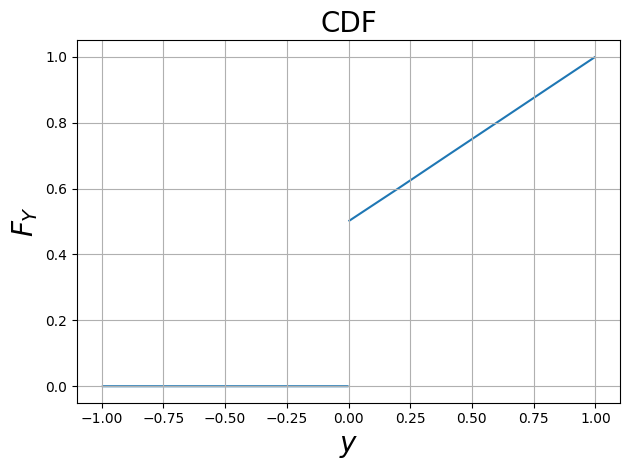

In [5]:
density.plot('CDF')

We first compute the projection of $\partial_y F(y)$ into $L^1(\Omega_Y)$ by specifying a discontinuous piecewise constant function space $V_{\tilde{f}}$ for $\tilde{f}(y)$ also known as 'DG0'. This choice naturally follows from the fact that $F(y)$ lives in 'DG1' and so its derivative should live in the lower order space 'DG0'.

In [11]:
def compute_f_tilde_pdf(F):
    """Compute f_tilde(y) as the derivative of CDF F(y) within the elements."""

    # Grab the mesh associated with the CDF
    mesh = F.function_space().mesh()

    # Define a function space for the PDF
    V_f_tilde = FunctionSpace(mesh=mesh,family="DG",degree=0);

    u = TrialFunction(V_f_tilde)
    v = TestFunction(V_f_tilde)

    # Define the variational form
    a = inner(u,v)*dx
    L = inner(F.dx(0),v)*dx

    # Solve for f_tilde
    f_tilde = Function(V_f_tilde)
    solve(a == L, f_tilde)
    
    return f_tilde

To realise the measure $\mu(y) = [[F(y)]]\delta(y)$ associated with the jump discontinuities at each facet, we can project the distribution into the space of continuous functions 'CG1' whose basis
\begin{equation}
\varphi_i(y_j) = \delta_{ij}, \quad \delta_{ij} = \begin{cases} 1 \quad i = j, \\ 0 \quad i \neq j, \end{cases}
\end{equation}
if restricted to the set of cell facets naturally represents our measure. To compute $[[F]]_e$ we make use of the $\texttt{jump}$ operator (part of the UFL form language) which evaluates the difference between the restrictions of the given expression on the positive and negative sides of the facet. The restriction to the cell facets is implemented by making use of the interior and exterior measures $\texttt{dS}$ and $\texttt{ds}$. At the exterior facets we impose the boundary condition $F(y_{min}) = 0, \; F(y_{max}) = 1$ in order to evaluate the jump and finally the $\texttt{avg}$ operator used below is also required when using $\texttt{dS}, \texttt{ds}$.

In [12]:
def compute_mu_pdf(F):
    """Compute the measure mu(y) as the distributional derivative of CDF F(y) at the element facets."""

    # Grab the mesh associated with the CDF
    mesh = F.function_space().mesh()
    
    # Define a function space for the test function
    V_mu = FunctionSpace(mesh=mesh, family="CG", degree=1)

    u = TrialFunction(V_mu)
    v = TestFunction(V_mu)

    # Define the variational form for the:
    #      interior facets                 exterior facets
    a = inner(avg(u),avg(v))*dS  +          inner(u,v)*ds
    L = -jump(F)*avg(v)*dS       -  ( (F-1)*v*ds(2) - (F-0)*v*ds(1) )

    # Solve for the measure
    mu = Function(V_mu)
    solve(a == L, mu)

    return mu

Having defined these two functions we then pass the CDF computed in order to recover the distribution $f(y)$ in terms of $\tilde{f}(y)$ and the measure $\mu(y)$.

In [8]:
# Compute the f_tilde(y) within the elements
f_tilde = compute_f_tilde_pdf(density.cdf)

# Compute the measure mu(y) at the element boundaries
mu = compute_mu_pdf(density.cdf)

Below we plot $\tilde{f}(y)$ and represent the measure $\mu(y)$ in terms of the dashed blue lines. 

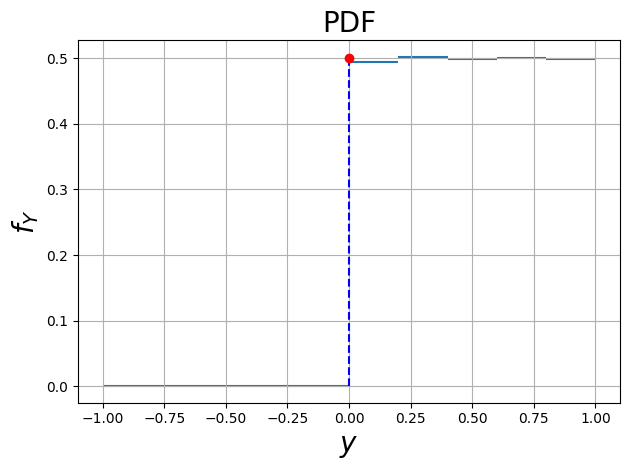

In [9]:
import matplotlib.pyplot as plt
from firedrake.pyplot import plot

# Plot the piecewise constant component
plot(f_tilde, num_sample_points=50)

# Plot the measure mu(y)
m_y = mu.function_space().mesh()
loc = m_y.coordinates.dat.data[:]
jump = mu.dat.data[:]

y = np.linspace(0,1,50)
for j_i,y_i in zip(jump,loc): 
    plt.plot(y_i*np.ones(50),j_i*y,'b--')
    if abs(j_i) > 1e-03: plt.plot(y_i,j_i,'ro')

# Label the plot
plt.title(r'PDF',fontsize=20)
plt.ylabel(r'$f_Y$',fontsize=20)
plt.xlabel(r'$y$',fontsize=20)
plt.tight_layout()
plt.grid()
plt.show()

Finally to check that this projection has conserved mass we integrate the distribution $f(y)$ below

In [10]:
#                 elements     external    internal
int_f = assemble(f_tilde*dx  +  mu*ds    + avg(mu)*dS)

print('int f_tilde(y) dy + \int d\mu(y) = %e' % int_f)

Without Dirac measure int f(y) dy = 4.989310e-01
With Dirac measure int f(y) dy + \int d\mu(y) = 1.000000e+00


In **Part 1** a discontinuous piecewise linear function space 'DG1' for $F(y)$ was justified by the need to maintain a non-decreasing and right-continuous function, which can be achieved by applying a slope limiter more easily for 'DG1' than for other higher order elements. Although this would be also guaranteed by choosing the space of piece-wise constant discontinuous functions 'DG0', the cell integral and the boundary terms in the previous equation would cancel, meaning that an additional approximation would need to be introduced in order to recover the PDF at these points. By choosing 'DG1' this issue is avoided and as evidenced by this notebook, 'DG1' also provides a convenient means for recovering the PDF (which may include a Dirac distribution) in a consistent fashion. One consequence of this definition of the PDF we must however bear in mind, is that we can only integrate $f(y)$ against test functions.